In [1]:
using Pkg; using Random; using Distributions; using DelimitedFiles; using Plots; using LinearAlgebra; gr()

Plots.GRBackend()

In [2]:
#Define space :

# Description of an experiment in a cavity
# The experiment here is in free space, uncomment to place yourself in the conditions of this experiment

struct Dimension
    Lx ::Float64  #length of the cavity along x-axis - in m
    Ly ::Float64
    Lz::Float64
    #origin of the x axis placed at the center of the cavity
    Bx ::Float64 #Lx/2 #extreme point along x axis
    By ::Float64
    Bz ::Float64
end

const Lx = 5. *10^(-3) #m
const Ly = 5. *10^(-3) #m
const Lz = 10. *10^(-3) #m

dimension = Dimension(Lx, Ly, Lz, Lx/2, Ly/2, Lz/2)

#General Physical constants:
struct Physics
    mu0 ::Float64  #T.m/A
    k_B ::Float64 #J/K
    e ::Float64 #C
    a0 ::Float64 #m #Bohr Radius
    c ::Float64 #m/s
    h ::Float64 #m².kg/s
end

physics = Physics(4*pi*10^(-7) , 1.3806504*10^(-23), 1.602176487*10^(-19), 0.52917720859*10^(-10), 299792458,6.62607004*10^(-34))        
#Initial Properties of Cesium gaz:
struct Cloud
    T ::Float64 #°K
    N ::Int64 #Number of Cesium atoms
end
cloud = Cloud( 0.1, 10)
#Model Cesium atoms as 2-level atoms:
#Transition Cs |6S(1/2) F = 4> -> Cs |6P(3/2) F = 5>
struct Particle
    m ::Float64  #kg
    wa ::Float64  #rad.s-1 #transition frequency
    γ ::Float64  #Hz #decay rate
    tau ::Float64  #s #lifetime
    vr ::Float64  #m.s-1 #recoil velocity
    wr ::Float64 #Hz #recoil "energy"
    Tr ::Float64  #K #recoil Temperature
    Td ::Float64  #K #doppler Temperature
    d ::Float64  
    Is ::Float64 #W/m^2 #Staturation Intensity for a σ+- light for a Cs |6S(1/2) F = 4, mF = +-4> -> Cs |6P(3/2) F = 5, mF = +-5>
end

cesium = Particle(2.2*10^(-25), 2*pi*351.72571850*10^(12),2*pi*5.18*10^6, 30.405*10^(-9), 3.5225 * 10^(-3), 2*pi*2.0663*10^3, 198.34 * 10^(-9), 125.61*10^(-6), 2.5886*physics.e*physics.a0, 11.049)
#Beam properties:
struct Beam
    Dl :: Float64  #m #diameter of the beam at the origin
    δ :: Float64  #s-1 #detuning frequency
    wl :: Float64  #rad.s-1 #laser frequency
    λ :: Float64   #m #laser wavelength
    k :: Float64 #rad.m-1 #laser wave number
    I0 :: Float64  #intensity at 
    w0 :: Float64 # = Dl/2 #cm 
    zR :: Float64 # = pi*w0^2/λ
    direction_x :: Int64
    direction_y :: Int64
    direction_z :: Int64
end

const w0 = 11/2*10^(-2)
const δ = -0.5*cesium.γ
const wl = cesium.wa + δ
const λ = 2*pi*physics.c/wl

#Beam A1 : sigma - polarized transverse gaussian light propagating in the direction -ex
#maximum intensity reached at the origin  
beam_A1 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, w0, pi*w0^2/λ, -1, 0, 0)
#Beam A2 : sigma + polarized transverse gaussian light propagating in the direction +ex  
#maximum intensity reached at the origin
beam_A2 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, w0, pi*w0^2/λ, 1, 0, 0)
#Beam B1 : sigma - polarized transverse gaussian light propagating in the direction -ey  
#maximum intensity reached at the origin
beam_B1 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, w0, pi*w0^2/λ, 0, -1, 0)
#Beam B2 : sigma + polarized transverse gaussian light propagating in the direction +ey 
#maximum intensity reached at the origin
beam_B2 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, w0, pi*w0^2/λ, 0, 1, 0)
#Beam C1 : Transverse gaussian sigma - polarized light propagating in the direction -ez  
#maximum intensity reached at the origin
beam_C1 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, w0, pi*w0^2/λ, 0, 0, -1)
#Beam C2 : sigma + polarized gaussian light propagating in the direction +ez  
#maximum intensity reached at the origin
beam_C2 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, w0, pi*w0^2/λ, 0, 0, 1)

beams = Vector{Beam}(undef,6)
beams[1] = beam_A1
beams[2] = beam_A2
beams[3] = beam_B1
beams[4] = beam_B2
beams[5] = beam_C1
beams[6] = beam_C2

#Simulation time :
struct Simulation
    t ::Float64  #s #time of the simulation
    dt ::Float64 ; #time step
    Nt ::Int64 ; # = convert(Int, round(t/dt))#number of iteration
end

const t = 10*10^(-3)
const dt = 0.1/cesium.γ
const Nt = convert(Int, round(t/dt))
simulation = Simulation(t, dt, Nt)

function Intensity(beam::Beam, dir::Float64, r2::Float64)

    return beam.I0/abs(1+(dir/beam.zR)^2)*exp(-2*r2/beam.w0^2/(1+(dir/beam.zR)^2))    

end

function s(particle::Particle, beam::Beam, x::Float64, y::Float64, z::Float64)
    dir = abs(beam.direction_x)*x+abs(beam.direction_y)*y+abs(beam.direction_z)*z
    r2 = (1-abs(beam.direction_x))*x^2+(1-abs(beam.direction_y))*y^2+(1-abs(beam.direction_z))*z^2
    return Intensity(beam, dir, r2)/particle.Is
end

s (generic function with 1 method)

In [3]:
#Let's plot the intensities of each beam over the space
X = range(-dimension.Bx, stop = dimension.Bx, length = 1000)
Y = range(-dimension.By, stop = dimension.By, length = 1000)
Z = range(-dimension.Bz, stop = dimension.Bz, length = 1000)

png(Plots.plot(X,Y,[cesium.Is*s(cesium,beam_A1,x,y,0.) for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "|EA1|²(x,y,0)", title = "Intensity of beam A1 over plane z = 0"), "IA1_new")
png(Plots.plot(X,Y,[cesium.Is*s(cesium,beam_B1,x,y,0.) for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "|EB1|²(x,y,0)", title = "Intensity  of beam B1 over plane z = 0"), "IB1_new")
png(Plots.plot(Y,Z,[cesium.Is*s(cesium,beam_C1,0.,y,z) for y in Y, z in Z],st=:surface, xlabel = "y(m)", ylabel = "z(m)", zlabel = "|EC1|²(0,y,z)", title = "Intensity  of beam C1 over plane x = 0"), "IC1_new")


In [4]:
print("wa = ",cesium.wa,"\n") 
print("δ = ", beam_A1.δ, "\n")
print("wl = ", beam_A1.wl, "\n")
print("λ = ", beam_A1.λ, "\n")
print("k = ", beam_A1.k, "\n")
print("γ = ",cesium.γ, "\n")
print("tau = ", cesium.tau, "\n")
print("Is =", cesium.Is, "\n")
print("Nt = ", simulation.Nt, "\n")
print("dt = ", simulation.dt, "\n")
print("zR = ", beam_A1.zR, "\n")
print(physics.h/2/pi/cesium.m*beam_A1.k)

wa = 2.2099578666363832e15
δ = -1.6273449945595128e7
wl = 2.2099578503629332e15
λ = 8.523472820983929e-7
k = 7.371625907823649e6
γ = 3.2546899891190257e7
tau = 3.0405000000000026e-8
Is =11.049
Nt = 3254690
dt = 3.0724892488782887e-9
zR = 11149.584185583273
0.003533594910711686

In [5]:
mutable struct System{A<:AbstractVector}
    position_x ::A 
    position_y ::A
    position_z ::A
    speed_x ::A
    speed_y ::A
    speed_z ::A
end

#Position vectors are taken randomly following a uniform distribution over space
particles_x = rand(range(-dimension.Bx, stop = dimension.Bx, length = 10000), cloud.N); 
particles_y = rand(range(-dimension.By, stop = dimension.By, length = 10000), cloud.N);
particles_z = rand(range(-dimension.Bz, stop = dimension.Bz, length = 10000), cloud.N);

#If you want to initialize by hand
#particles_x = [-2*dimension.Bx, -dimension.Bx, -dimension.Bx/2, -dimension.Bx /4, 0, dimension.Bx/8, dimension.Bx/4, dimension.Bx/2, dimension.Bx, 2*dimension.Bx]
#particles_y = zeros(cloud.N)
#particles_z = zeros(cloud.N)

#Velocity vectors are taken randomly following a Maxwell-Boltzmann distribution over space
#Equivalent : Each component of each velocity vector is taken randomly following a Gaussian distribution over space

d = Normal() #Normal distribution
sigma = sqrt(physics.k_B*cloud.T/cesium.m) #Variance
particles_vx = sigma*rand(d, cloud.N);
particles_vy = sigma*rand(d, cloud.N);
particles_vz = sigma*rand(d, cloud.N);

#Arbitrary Velocity vectors
#particles_vx = -10.0*ones(cloud.N)
#particles_vy = zeros(cloud.N)
#particles_vz = zeros(cloud.N)

system = System(particles_x, particles_y, particles_z, particles_vx, particles_vy, particles_vz)

System{Array{Float64,1}}([0.0021699669966996704, 0.001444894489448945, 0.0021539653965396543, 0.00032778277827782786, 0.0002417741774177418, 0.0008753375337533755, -0.002338483848384839, -0.0013173817381738177, -0.002321482148214822, 0.0005278027802780279], [0.0009413441344134415, 0.0007333233323332334, 0.0010733573357335736, -0.0024849984998499856, -0.0024779977997799784, 0.0008038303830383039, 0.0005618061806180619, -0.0016264126412641267, -0.002003450345034504, 0.0004937993799379939], [0.004294929492949295, -0.001561656165616562, -0.0005335533553355337, -0.0007835783578357837, -0.00468896889688969, 0.00043754375437543764, -0.002437743774377438, -0.0032738273827382747, -0.0039838983898389845, 0.0035938593859385945], [-2.78116219461467, -3.5518754332472375, 0.6362905580357618, -1.6821026921616469, 3.312209435844778, -0.1690443566878448, 1.0142041820756356, -0.5782540282603494, -2.786416081259277, -2.9072867200235573], [-3.069030303192883, -1.2710782245407877, 5.063007662089635, -2.016

In [6]:
function mean_speed_squared(cloud::Cloud, system::System)
    
    #returns the instantaneous temperature of the system T= m/(degree_of_freedom*N*k_B)*sum_{i=1,N}(v_i^2) 
    #Here we have 1 degree of freedom

    return 1/cloud.N*sum(system.speed_x.^2 .+ system.speed_y.^2 .+ system.speed_y.^2 )
end

function mean(cloud::Cloud, system::System)

  #compute the mean of the system

  return [sum(system.speed_x), sum(system.speed_y), sum(system.speed_z)]/cloud.N
  
end 

mean (generic function with 1 method)

In [7]:
mean_speed_squared(cloud, system)

20.461401188373294

In [8]:
mean(cloud, system)

3-element Array{Float64,1}:
 -0.9493437330298408
  0.6353996991500072
  0.2528555540932166

In [9]:
function step!(dimension::Dimension, physics::Physics, particle::Particle, cloud::Cloud, beams::Vector{Beam}, simulation::Simulation, system::System, system_over_time ::Vector{System})
    
    rva = Vector{Float64}(undef, cloud.N)
    rho_ee = Vector{Float64}(undef, cloud.N)
    theta = Vector{Float64}(undef, cloud.N)
    phi = Vector{Float64}(undef, cloud.N)
    scatter_event = Vector{Float64}(undef, cloud.N)
    
    for j = 2 : simulation.Nt #at each time step
        for beam in beams
            
            rva = rand(Float64, cloud.N)
            rho_ee .= simulation.dt .* particle.γ .* s.([particle], [beam], system.position_x, system.position_y, system.position_z) ./ 2 ./ (1 .+ s.([particle], [beam], system.position_x, system.position_y, system.position_z) .+ (2 .*(beam.δ .- beam.direction_x .* beam.k .* system.speed_x .- beam.direction_y .* beam.k .* system.speed_y .- beam.direction_z .* beam.k .* system.speed_z) ./ particle.γ) .^2) #laser1
            
            scatter_event .= physics.h ./ 2. ./ pi ./ particle.m .* beam.k .* (rva .< rho_ee)
            theta = 2*pi*rand(Float64, cloud.N) #random inclination of the emitted photon
            phi = 2*pi*rand(Float64, cloud.N) #random azimuth of the emitted photon
            
            system.speed_x .= system.speed_x .+  scatter_event .*(beam.direction_x .+ sin.(theta).*cos.(phi)) 
            system.speed_y .= system.speed_y .+  scatter_event .*(beam.direction_y .+ sin.(theta).*sin.(phi)) 
            system.speed_z .= system.speed_z .+  scatter_event .*(beam.direction_z .+ cos.(theta)) 
        end
        
        system.position_x .= system.position_x .+ system.speed_x .*simulation.dt
        system.position_y .= system.position_y .+ system.speed_y .*simulation.dt
        system.position_z .= system.position_z .+ system.speed_z .*simulation.dt
        
        system_over_time[j] = deepcopy(system)
    end
end

function experiment(dimension::Dimension, physics::Physics, particle::Particle, cloud::Cloud, beams::Vector{Beam}, simulation::Simulation, system::System)

    system_over_time = Vector{System}(undef,simulation.Nt)
    
    system_over_time[1] = deepcopy(system)
    
    step!(dimension, physics, particle, cloud, beams, simulation, system, system_over_time)
    
    return system_over_time
end

experiment (generic function with 1 method)

In [10]:
@time system_over_time = experiment(dimension, physics, cesium, cloud, beams, simulation, system)

210.095947 seconds (307.75 M allocations: 39.974 GiB, 13.52% gc time)


3254690-element Array{System,1}:
 System{Array{Float64,1}}([0.0021699669966996704, 0.001444894489448945, 0.0021539653965396543, 0.00032778277827782786, 0.0002417741774177418, 0.0008753375337533755, -0.002338483848384839, -0.0013173817381738177, -0.002321482148214822, 0.0005278027802780279], [0.0009413441344134415, 0.0007333233323332334, 0.0010733573357335736, -0.0024849984998499856, -0.0024779977997799784, 0.0008038303830383039, 0.0005618061806180619, -0.0016264126412641267, -0.002003450345034504, 0.0004937993799379939], [0.004294929492949295, -0.001561656165616562, -0.0005335533553355337, -0.0007835783578357837, -0.00468896889688969, 0.00043754375437543764, -0.002437743774377438, -0.0032738273827382747, -0.0039838983898389845, 0.0035938593859385945], [-2.78116219461467, -3.5518754332472375, 0.6362905580357618, -1.6821026921616469, 3.312209435844778, -0.1690443566878448, 1.0142041820756356, -0.5782540282603494, -2.786416081259277, -2.9072867200235573], [-3.069030303192883, -1.271078224

In [11]:
const position_x_over_time = [system_over_time[i].position_x for i=1:Nt]
const position_y_over_time = [system_over_time[i].position_y for i=1:Nt]
const position_z_over_time = [system_over_time[i].position_z for i=1:Nt]
const speed_x_over_time = [system_over_time[i].speed_x for i=1:Nt]
const speed_y_over_time = [system_over_time[i].speed_y for i=1:Nt]
const speed_z_over_time = [system_over_time[i].speed_z for i=1:Nt]

3254690-element Array{Array{Float64,1},1}:
 [3.947827959744498, 2.8153753311892875, -1.1567152088714896, -2.554808923178286, 1.430330144064027, 5.493566740291304, 0.2845644967914605, -1.115620974863353, -2.0125581317203673, -4.603405892514915]
 [3.947827959744498, 2.8153753311892875, -1.1567152088714896, -2.554808923178286, 1.430330144064027, 5.493566740291304, 0.2845644967914605, -1.115620974863353, -2.0125581317203673, -4.603405892514915]
 [3.947827959744498, 2.8153753311892875, -1.1567152088714896, -2.554808923178286, 1.430330144064027, 5.493566740291304, 0.2845644967914605, -1.115620974863353, -2.0125581317203673, -4.603405892514915]
 [3.947827959744498, 2.8153753311892875, -1.1567152088714896, -2.554808923178286, 1.430330144064027, 5.493566740291304, 0.2845644967914605, -1.115620974863353, -2.0125581317203673, -4.603405892514915]
 [3.947827959744498, 2.8153753311892875, -1.1567152088714896, -2.554808923178286, 1.430330144064027, 5.493566740291304, 0.2845644967914605, -1.1156209748

In [12]:
time = [k*simulation.dt for k=1:simulation.Nt]

3254690-element Array{Float64,1}:
 3.0724892488782887e-9
 6.144978497756577e-9
 9.217467746634866e-9
 1.2289956995513155e-8
 1.5362446244391444e-8
 1.843493549326973e-8
 2.1507424742148022e-8
 2.457991399102631e-8
 2.7652403239904597e-8
 3.072489248878289e-8
 3.3797381737661175e-8
 3.686987098653946e-8
 3.994236023541775e-8
 ⋮
 0.009999966236049939
 0.009999969308539188
 0.009999972381028437
 0.009999975453517686
 0.009999978526006936
 0.009999981598496185
 0.009999984670985434
 0.009999987743474681
 0.00999999081596393
 0.00999999388845318
 0.009999996960942429
 0.010000000033431678

In [13]:
mean_speed_squared_over_time = [mean_speed_squared(cloud, system_over_time[i]) for i = 1 : simulation.Nt]

3254690-element Array{Float64,1}:
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.461401188373294
 20.45876273846096
 20.45876273846096
 20.45876273846096
 20.45876273846096
  ⋮
  0.021000410435332663
  0.021000410435332663
  0.021000410435332663
  0.021000410435332663
  0.021019969803492564
  0.021019969803492564
  0.021065247619683036
  0.021065247619683036
  0.021111521089993014
  0.021111521089993014
  0.021111521089993014
  0.021225592050534807

In [14]:
#We are interested in the squared speed over time
png(Plots.plot(time, mean_speed_squared_over_time, title = "Mean of the squared speed over time", xlabel = "t (s)", ylabel = "<v²>(t) (°K)"), "Squared_speed_3D6lasers") 

In [15]:
mean_over_time = [mean(cloud, system_over_time[i]) for i=1:Nt] 

3254690-element Array{Array{Float64,1},1}:
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9493437330298408, 0.6353996991500072, 0.2528555540932166]
 [-0.9488359469095726, 0.635515392185478, 0.25315157853083736]
 [-0.9488359469095726, 0.635515392185478, 0.25315157853083736]
 [-0.9488359469095726, 0.635515392185478, 0.25315157853083736]
 [-0.9488359469095726, 0.635515392185478, 0.25315157853083736]
 ⋮
 [0.006772999696601521, 0.019363051116170468, 0.0236993012458818]
 [0.006772999696601521, 0.019363051116170468, 0.0236993012458818]
 [0

In [16]:
#We are interested in the mean over time

png(Plots.plot(time, [mean[1] for mean in mean_over_time], title = "Mean speed along x absciss over time", xlabel = "t (s)", ylabel = "<vx>(t) (m/s)"), "Meanx_3D6lasers")
png(Plots.plot(time, [mean[2] for mean in mean_over_time], title = "Mean speed along y absciss over time", xlabel = "t (s)", ylabel = "<vy>(t) (m/s)"), "Meany_3D6lasers")
png(Plots.plot(time, [mean[3] for mean in mean_over_time], title = "Mean speed along z absciss over time", xlabel = "t (s)", ylabel = "<vz>(t) (m/s)"), "Meanz_3D6lasers")

In [17]:
variance_over_time = [mean_speed_squared_over_time[i] - norm(mean_over_time[i]) for i=1:simulation.Nt]

3254690-element Array{Float64,1}:
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.291391687403863
 19.289038330933653
 19.289038330933653
 19.289038330933653
 19.289038330933653
  ⋮
 -0.010343778068449806
 -0.010343778068449806
 -0.010343778068449806
 -0.010343778068449806
 -0.01088854464341741
 -0.01088854464341741
 -0.010811805474627838
 -0.010811805474627838
 -0.011211208597967308
 -0.011211208597967308
 -0.011211208597967308
 -0.010746970964764166

In [18]:
#We are interested in the variance over time
png(Plots.plot(time, variance_over_time, title = "Variance over time", xlabel = "t (s)", ylabel = "<v²(t)>-<v(t)>² (m/s)²"), "Variance_3D6lasers")

In [19]:
file_data = string("simulation_data.txt")#stores the data of the particles over time
touch(file_data)

"simulation_data.txt"

In [20]:
#We are interested in the minimum speed reached by the system
min_v = minimum(mean_speed_squared_over_time)
data1 = string("minimum speed reached : ",sqrt(min_v)," m.s-1")
print(data1)
writedlm(file_data, data1)

minimum speed reached : 0.0731848608595388 m.s-1

In [31]:
1/3*min_v*cesium.m/physics.k_B

2.8448554608432194e-5

In [21]:
#We are interested in the time it takes to get this speed
min_v_reached = findfirst(isequal(min_v),mean_speed_squared_over_time)
data2 = string("minimum speed is reached after ", min_v_reached*dt, " s (that is, after ", min_v_reached," iteration)")
print(data2)
writedlm(file_data, [readdlm(file_data), data2])

minimum speed is reached after 0.009691632722457258 s (that is, after 3154326 iteration)

In [22]:
#We are interested in the maximum variance reached
data3 = string("maximum variance reached : ", maximum(variance_over_time), " m2.s-2")
print(data3)
writedlm(file_data, [readdlm(file_data), data3])

maximum variance reached : 19.296177240231394 m2.s-2

In [23]:
#We are interested in the dynamics of the atoms over time
for i = 1:cloud.N
    pltvx = Plots.plot(time,[speed_x_over_time[j][i] for j in 1:simulation.Nt], title = "Projected speed on x over time", xlabel = "t (s)", ylabel = "vx(t) (m/s)")  
    pltvy = Plots.plot(time,[speed_y_over_time[j][i] for j in 1:simulation.Nt], title = "Projected speed on y over time", xlabel = "t (s)", ylabel = "vy(t) (m/s)")
    pltvz = Plots.plot(time,[speed_z_over_time[j][i] for j in 1:simulation.Nt], title = "Projected speed on z over time", xlabel = "t (s)", ylabel = "vz(t) (m/s)")  

    pltx = Plots.plot(time,[position_x_over_time[j][i] for j in 1:simulation.Nt], title = "Position x over time", xlabel = "t (s)", ylabel = "x(t) (m)")  
    plty = Plots.plot(time,[position_y_over_time[j][i] for j in 1:simulation.Nt], title = "Position y over time", xlabel = "t (s)", ylabel = "y(t) (m)")
    pltz = Plots.plot(time,[position_z_over_time[j][i] for j in 1:simulation.Nt], title = "Position z over time", xlabel = "t (s)", ylabel = "z(t) (m)")  

    #show the two graphics on the same image
    png(Plots.plot(pltvx, pltx, layout = (2,1)), string("movement_x_part_",string(i),"_3D6lasers"))
    png(Plots.plot(pltvy, plty, layout = (2,1)), string("movement_y_part_",string(i),"_3D6lasers"))
    png(Plots.plot(pltvz, pltz, layout = (2,1)), string("movement_z_part_",string(i),"_3D6lasers"))  
end

In [24]:
v2max = [speed_x_over_time[i].^2+speed_y_over_time[i].^2+speed_z_over_time[i].^2 for i=1:simulation.Nt]

3254690-element Array{Array{Float64,1},1}:
 [32.73915575441049, 22.157797201676203, 27.376902335058432, 13.421215319538163, 13.881269687969263, 31.00127417646173, 8.350351341967304, 1.8260668407022425, 11.953881675439533, 55.85012879206276]
 [32.73915575441049, 22.157797201676203, 27.376902335058432, 13.421215319538163, 13.881269687969263, 31.00127417646173, 8.350351341967304, 1.8260668407022425, 11.953881675439533, 55.85012879206276]
 [32.73915575441049, 22.157797201676203, 27.376902335058432, 13.421215319538163, 13.881269687969263, 31.00127417646173, 8.350351341967304, 1.8260668407022425, 11.953881675439533, 55.85012879206276]
 [32.73915575441049, 22.157797201676203, 27.376902335058432, 13.421215319538163, 13.881269687969263, 31.00127417646173, 8.350351341967304, 1.8260668407022425, 11.953881675439533, 55.85012879206276]
 [32.73915575441049, 22.157797201676203, 27.376902335058432, 13.421215319538163, 13.881269687969263, 31.00127417646173, 8.350351341967304, 1.8260668407022425, 11.953

┌ Info: Saved animation to 
│   fn = D:\Users\Antoine\Documents\copenhague-1\togit\togit\Laser cooling\3D\3D6Lasers\Optical Molass\simulation_3D6Lasers.gif
└ @ Plots D:\Users\Antoine\.julia\packages\Plots\lmp2A\src\animation.jl:104


Plots.AnimatedGif("D:\\Users\\Antoine\\Documents\\copenhague-1\\togit\\togit\\Laser cooling\\3D\\3D6Lasers\\Optical Molass\\simulation_3D6Lasers.gif")
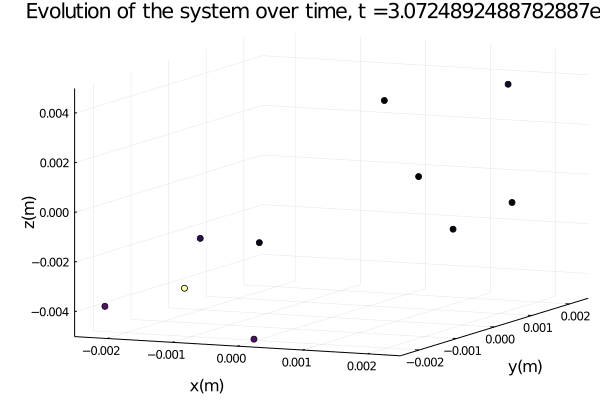

In [25]:
anim = Animation()

for j in range(1, step=1000000, stop = simulation.Nt+1) 

    X = range(-dimension.Bx, stop = dimension.Bx, length = 100)
    Y = range(-dimension.By, stop = dimension.By, length = 100)
    Z = range(-dimension.Bz, stop = dimension.Bz, length = 100)
    
    #Plots.plot(range(-beam_A1.w0, stop = beam_A1.w0, length = 100),Y,[sqrt(beam_A1.w0^2-x^2) for x in range(-beam_A1.w0, stop = beam_A1.w0, length = 100), y in Y],st=:surface, c=:blues, opacity = 0.3, leg = false, camera = (-30,30) )
    #Plots.plot!(range(-beam_A1.w0, stop = beam_A1.w0, length = 100),Y,[-sqrt(beam_A1.w0^2-x^2) for x in range(-beam_A1.w0, stop = beam_A1.w0, length = 100), y in Y],st=:surface, c=:blues, opacity = 0.3, leg = false, camera = (-30,30))
    Plots.scatter(system_over_time[j].position_x,system_over_time[j].position_y,system_over_time[j].position_z, title = string("Evolution of the system over time, t =", j*dt, " s"), xlabel = "x(m)", ylabel = "y(m)", zlabel = "z(m)", xlim = (-dimension.Bx,dimension.Bx), ylim = (-dimension.By,dimension.By), zlim = (-dimension.Bz,dimension.Bz), marker_z = 1 ./ v2max[j] .* (system_over_time[j].position_x.^2 .+ system_over_time[j].position_y.^2 .+ system_over_time[j].position_z.^2), leg = false)
    #Plots.plot!(X,range(-beam_A1.w0, stop = beam_A1.w0, length = 100),[sqrt(beam_A1.w0^2-y^2) for x in X, y in range(-beam_A1.w0, stop = beam_A1.w0, length = 100)],st=:surface, c=:blues, opacity = 0.3,  leg = false, camera = (-30,30))
    #Plots.plot!(X,range(-beam_A1.w0, stop = beam_A1.w0, length = 100),[-sqrt(beam_A1.w0^2-y^2) for x in X, y in range(-beam_A1.w0, stop = beam_A1.w0, length = 100)],st=:surface, c = :blues, opacity = 0.3, leg = false, camera = (-30,30))

    Plots.frame(anim)
end
gif(anim, "simulation_3D6Lasers.gif", fps=1)

┌ Info: Saved animation to 
│   fn = D:\Users\Antoine\Documents\copenhague-1\togit\togit\Laser cooling\3D\3D6Lasers\Optical Molass\speed_distribution_1D1Laser_doppler.gif
└ @ Plots D:\Users\Antoine\.julia\packages\Plots\lmp2A\src\animation.jl:104


Plots.AnimatedGif("D:\\Users\\Antoine\\Documents\\copenhague-1\\togit\\togit\\Laser cooling\\3D\\3D6Lasers\\Optical Molass\\speed_distribution_1D1Laser_doppler.gif")
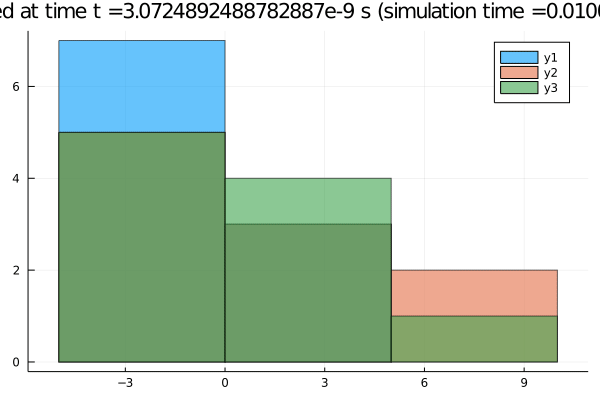

In [26]:
#distribution of speed
anim = Animation()

for k in range(1, step=10000, stop=Nt+1)
    #plot(xlim = (-Bx, Bx),ylim = (-1, 1))    
    Plots.histogram([speed_x_over_time[k] speed_y_over_time[k] speed_z_over_time[k]],opacity = 0.6, title = string("Distribution of speed at time t =", k*simulation.dt, " s (simulation time =",simulation.t, " s)"))
    Plots.frame(anim)
end
gif(anim, "speed_distribution_1D1Laser_doppler.gif", fps=3)

In [27]:
for i =1:cloud.N
    plt = plot3d(
    1,
    xlim = (-dimension.Bx, dimension.Bx),
    ylim = (-dimension.By, dimension.By),
    zlim = (-dimension.Bz, dimension.Bz),
    title = string("Trajectory of particle", string(i)),
    xlabel = "x (m)",
    ylabel = "y (m)",
    zlabel = "z (m)",
    marker = 2)
    for j in range(1, step=10000, stop=simulation.Nt+1)
        push!(plt, system_over_time[j].position_x[i] ,system_over_time[j].position_y[i],system_over_time[j].position_z[i])
    end
    png(plt, string("traj_",string(i),"_3D6lasers_0.001"))
end
# build an animated gif by pushing new points to the plot, saving every 10th frame

After each simulation, we add the simulated atoms to a storage file

In [67]:
#file storing the position
file_position = string("position_T_",cloud.T,".txt")#stores the position of the particles over time
touch(file_position)

#file storing the speed
file_speed = string("speed_T_",cloud.T,".txt") #stores the position of the particles over time
touch(file_speed) #create the file if it does not exist

"speed_T_1.0.txt"

In [ ]:
#add the new positions to the file
open(file_position, "a") do io
       writedlm(io, [position_x_over_time, position_y_over_time, position_z_over_time])
       end
       
#add the new speeds to the file
open(file_speed, "a") do io
       writedlm(io, [speed_x_over_time, speed_y_over_time, speed_z_over_time])
       end

Let's now interest ourselves on the force applied on the system

In [ ]:
#Method 1 : Sliding Mean
#Step A : smooth the the mean_over_time

p = 1000 #smooth parameter
proper_mean_speed = []

for j in p:Nt+1

   append!(proper_mean_speed, sum(mean_over_time[j-p+1:j])/p)

end
png(plot(time[p:Nt+1],proper_mean_speed, xlabel = "t (s)", ylabel = "<v(t)> (m.s-1)"), "Mean_speed_over_time_filtered")

In [ ]:
#Step B : Compute its derivative over time

derivative_mean_speed = []

for j in 2:Nt+2-p

    append!(derivative_mean_speed,(proper_mean_speed[j]-proper_mean_speed[j-1])/dt)

end

In [ ]:
#Step C : We are interested in comparing the computed derivative of the speed with the theory
expected_derivative = []
for speed in proper_mean_speed[2:Nt+2-p]
    append!(expected_derivative, 1/m*h/2/pi*k*γ/2*s(0)*(1/(1+s(0)+(2*(δ-k*speed)/γ)^2)))
end

In [ ]:
#Step D : Show the unfiltered derivative and compare it with the theory
#Plot the derivative of the speed as a function of the speed
#Plot the expected value of the Fore 
plt1 = plot(proper_mean_speed[2:Nt+2-p], derivative_mean_speed, label = "computed", title = "Derivative of mean speed in function of mean speed", xlabel = "<v>(t) (m.s-1)", ylabel = "d<v(t)>/dt (m/s)")
plot!(proper_mean_speed[2:Nt+2-p], expected_derivative, label = "theory") 
png(plt1, "Forces_1D1Laser")

In [ ]:
test2 = [[1;2];[1;2];[1;2]]
file_data = "mytestfile.txt"#stores the data of the particles over time
touch(file_data)
open(file_data, "a") do io
       writedlm(io, test2)
       end
result_test = readdlm(file_data)
print(result_test)